# Classifier using PyTorch

In this notebook we train an MLP classifier on the MINST dataset.

In [4]:
import numpy as np
import torch
import torchvision
from torch import nn, optim
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

# replace with your own root directory
ROOT="./"

Load the MNIST dataset. This will download a copy to your machine on first use. 

In [5]:
# Load the datasets
train_set = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_set = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

Inspect some of the data.

In [3]:
data, label = train_set[9]
print(data.size())
print(label)


torch.Size([1, 28, 28])
4


Create some iterable Data Loaders for easy iteration on mini-batches during training and testing. Also, initialise an array with the 10 class IDs.

In [6]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=16,
    shuffle=True,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=24, # Forward pass only so batch size can be larger
    shuffle=False,
    num_workers=2
)

classes = np.arange(0, 10)
print(classes)

[0 1 2 3 4 5 6 7 8 9]


Show some images and labels as a sanity check.
Use `torchvision.utils.make_grid` to create one image from a set of images. Note that this function converts single channel (grey-scale) tensors to have three channels. This is done by replicating the values into red, green and blue channels.

torch.Size([16, 1, 28, 28])


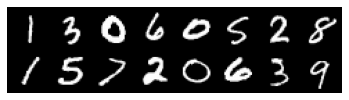

1 3 0 6 0 5 2 8 1 5 7 2 0 6 3 9


In [7]:
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.axis('off')
    plt.show()
    return xa
    
# get a batch of random training examples (images and corresponding labels)
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images and labels
print(images.size())
timshow(torchvision.utils.make_grid(images))
print(*labels.numpy())     # asterisk unpacks the ndarray


## Build a classifier
Instead of defining the classifier function, loss function and parameter updates directly as we did in PyTorch.ipynb, it is convenient to use the `torch.nn` and `torch.optim` packages. These provide a simple way to build networks without losing sight of the iterative steps in gradient descent.

First we construct the classifer function using the nn.Sequential wrapper that simply sequences the steps in the classifier function. In the case of a linear classifier there is just one nn.Linear layer. This is preceeded by `nn.Flatten` that vectorises a $28\times28$ input image into a 1D vector of length $28*28$. We will also experiment with a two layer classifier.

In [8]:
net = nn.Sequential(
    nn.Flatten(),
    
    # single layer
    #nn.Linear(28*28, 10)
    
    # two layers
    nn.Linear(28*28, 300),
    nn.ReLU(),
    nn.Linear(300,10)
)

for param in net.parameters():
    print(param.shape)


torch.Size([300, 784])
torch.Size([300])
torch.Size([10, 300])
torch.Size([10])


Train the network. For the two-layer network you'll need at least 200 epochs. 50 epochs will be more than enough for the one-layer network, but we'll run for the same number of epochs as for the two-layer network to give the full curve in the plot below.

In [21]:
nepochs = 200    # number of epochs
results_path = ROOT + 'data/results/linear2layer200epochs.pt'

# initialise ndarray to store the mean loss in each epoch (on the training data)
losses = np.zeros(nepochs)

# Use a loss function and optimiser provided as part of PyTorch.
# The chosen optimiser (Stochastic Gradient Descent with momentum) needs only to be given the parameters (weights and biases)
# of the network and updates these when asked to perform an optimisation step below.
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(nepochs):  # loop over the dataset multiple times

    # initialise variables for mean loss calculation
    running_loss = 0.0
    n = 0
    
    for data in train_loader:
        inputs, labels = data
        
        # Zero the parameter gradients to remove accumulated gradient from a previous iteration.
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
        # accumulate loss and increment minibatches
        running_loss += loss.item()
        n += 1
       
    # record the mean loss for this epoch and show progress
    losses[epoch] = running_loss / n
    print(f"epoch: {epoch+1} loss: {losses[epoch] : .3f}")
    
#save network parameters and losses
torch.save({"state_dict": net.state_dict(), "losses": losses}, results_path)
   

epoch: 1 loss:  0.625
epoch: 2 loss:  0.306
epoch: 3 loss:  0.257
epoch: 4 loss:  0.221
epoch: 5 loss:  0.194
epoch: 6 loss:  0.172
epoch: 7 loss:  0.154
epoch: 8 loss:  0.140
epoch: 9 loss:  0.127
epoch: 10 loss:  0.117
epoch: 11 loss:  0.108
epoch: 12 loss:  0.100
epoch: 13 loss:  0.094
epoch: 14 loss:  0.088
epoch: 15 loss:  0.083
epoch: 16 loss:  0.078
epoch: 17 loss:  0.074
epoch: 18 loss:  0.070
epoch: 19 loss:  0.066
epoch: 20 loss:  0.063
epoch: 21 loss:  0.060
epoch: 22 loss:  0.057
epoch: 23 loss:  0.054
epoch: 24 loss:  0.052
epoch: 25 loss:  0.050
epoch: 26 loss:  0.047
epoch: 27 loss:  0.045
epoch: 28 loss:  0.043
epoch: 29 loss:  0.042
epoch: 30 loss:  0.040
epoch: 31 loss:  0.038
epoch: 32 loss:  0.037
epoch: 33 loss:  0.036
epoch: 34 loss:  0.034
epoch: 35 loss:  0.033
epoch: 36 loss:  0.032
epoch: 37 loss:  0.031
epoch: 38 loss:  0.029
epoch: 39 loss:  0.028
epoch: 40 loss:  0.027
epoch: 41 loss:  0.026
epoch: 42 loss:  0.026
epoch: 43 loss:  0.025
epoch: 44 loss:  0.0

Notice that the first dimension of inputs and outputs corresponds to a minibatch of examples.

In [9]:
print(f"input size: {inputs.size()}, output size: {outputs.size()}")

NameError: name 'inputs' is not defined

Compare the history of the loss function during training (mean loss in each epoch) for 1 and 2 layer models

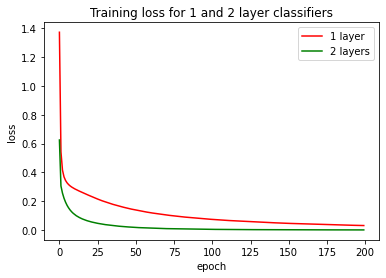

In [10]:
d1 = torch.load('./data/results/linear1layer200epochs.pt')
d2 = torch.load('./data/results/linear2layer200epochs.pt')

fig = plt.figure()

plt.plot(d1["losses"], 'r', label = '1 layer', )
plt.plot(d2["losses"], 'g', label = '2 layers' )
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training loss for 1 and 2 layer classifiers')

fig.savefig("training_loss_MNIST.svg")
plt.show()

How does the trained classifier `net` perform on the test set? First define our performance measures in terms of a given confusion matrix.

In [30]:
def accuracy(cnfm):
    return cnfm.trace()/cnfm.sum((0,1))

def recalls(cnfm):
    return np.diag(cnfm)/cnfm.sum(1)

def precisions(cnfm):
    return np.diag(cnfm)/cnfm.sum(0)    

Run the model on test data, build a confusion matrix and compute performance measures.

In [28]:
d = torch.load(ROOT+'data/results/linear2layer200epochs.pt')
# now load the parameter state into the current model (make sure this is the right model).
net.load_state_dict(d["state_dict"])

# initialise confusion matrix
nclasses = classes.shape[0]
cnfm = np.zeros((nclasses,nclasses),dtype=int)

# work without gradient computation since we are testing (i.e. no optimisation)
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        
        # find the class with the highest output.
        # note that the outputs are confidence values since we didn't need to apply softmax in our network
        # (nn.crossentropyloss takes raw condifence values and does its own softmax)   
        _, predicted = torch.max(outputs, 1)    
       
        
        # accumulate into confusion matrix
        for i in range(labels.size(0)):
            cnfm[labels[i].item(),predicted[i].item()] += 1
              
print("Confusion matrix")
for i in range (0,30):
    cnfm[i]=(cnfm[i]/sum(cnfm[i]))*100
print(cnfm)
# show confusion matrix as a grey-level image
plt.imshow(cnfm, cmap='gray')

# show per-class recall and precision
print(f"Accuracy: {accuracy(cnfm) :.1%}")
r = recalls(cnfm)
p = precisions(cnfm)
for i in range(nclasses):
    print(f"Class {classes[i]} : Precision {p[i] :.1%}  Recall {r[i] :.1%}")


TypeError: only size-1 arrays can be converted to Python scalars

## Defining a bespoke model class

In the above, we have used the 'container' module `nn.Sequential` to define our network. To give more flexibility in the definition of the network, we can replace this with our own `nn.module` as below. Notice here, we have used this flexibility to perform the flattening ourselves instead of using `nn.Flatten` - this will be more efficient.

In [3]:
class Classifier(nn.Module):
    
    def __init__(self, num_classes=10):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(28 * 28, num_classes)
        
    def forward(self, x):
        out = x.reshape(x.size(0), -1) # flatten the input
        out = self.fc1(out)
        return out
    
net = Classifier()
print(net)

Classifier(
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)


## Exercise
Experiment with the impact on accuracy of (1) adding a third fully-connected linear layer to the network and (2) replacing `nn.Sigmoid` by `nn.ReLU`.